In [64]:
import numpy as np
import os
import torch
content_path = '/home/yifan/full_checkpoint'
model_path  = os.path.join(content_path)
Epoch = 26
ENCODER_DIMS= [768,512,256,256,256,256,2]
DECODER_DIMS= [2,256,256,256,256,512,768]
GPU_ID = 0
PATIENT = 5
MAX_EPOCH = 10
Epoch_name = 'ckpt_epc'
S_N_EPOCHS = 5
VIS_MODEL_NAME = 'text'
DEVICE = torch.device("cuda:{}".format(GPU_ID) if torch.cuda.is_available() else "cpu")
train_representation = np.load(os.path.join(model_path, '{}{}'.format(Epoch_name,Epoch), 'train_data.npy'))
test_representation = np.load(os.path.join(model_path, '{}{}'.format(Epoch_name,Epoch), 'test_data.npy'))

In [54]:
from pynndescent import NNDescent
from sklearn.utils import check_random_state
from umap.umap_ import fuzzy_simplicial_set, make_epochs_per_sample

def _construct_fuzzy_complex(train_data, n_neighbors=15,metric="euclidean"):
        # """
        # construct a vietoris-rips complex
        # """
        # number of trees in random projection forest
        n_trees = min(64, 5 + int(round((train_data.shape[0]) ** 0.5 / 20.0)))
        # max number of nearest neighbor iters to perform
        n_iters = max(5, int(round(np.log2(train_data.shape[0]))))
        # distance metric
        # # get nearest neighbors
        
        nnd = NNDescent(
            train_data,
            n_neighbors=n_neighbors,
            metric=metric,
            n_trees=n_trees,
            n_iters=n_iters,
            max_candidates=60,
            verbose=True
        )
        knn_indices, knn_dists = nnd.neighbor_graph
        random_state = check_random_state(42)
        complex, sigmas, rhos = fuzzy_simplicial_set(
            X=train_data,
            n_neighbors=n_neighbors,
            metric=metric,
            random_state=random_state,
            knn_indices=knn_indices,
            knn_dists=knn_dists
        )
        return complex, sigmas, rhos, knn_indices

In [55]:
complex, _,_,_ = _construct_fuzzy_complex(train_representation)

Tue Dec 19 13:38:52 2023 Building RP forest with 21 trees
Tue Dec 19 13:38:56 2023 NN descent for 17 iterations
	 1  /  17
	 2  /  17
	 3  /  17
	 4  /  17
	 5  /  17
	 6  /  17
	 7  /  17
	 8  /  17
	Stopping threshold met -- exiting after 8 iterations


In [56]:
from singleVis.backend import get_graph_elements, get_attention
from singleVis.utils import *

In [57]:
def get_graph(feature_vectors, complex):
    _, head, tail, weight, _ = get_graph_elements(complex, 5)
    attention = np.zeros(feature_vectors.shape)
    return head, tail, weight, feature_vectors, attention

In [58]:
edge_to, edge_from, probs, feature_vectors, attention  = get_graph(train_representation, complex)

In [59]:
from singleVis.edge_dataset import DVIDataHandler
probs = probs / (probs.max()+1e-3)
eliminate_zeros = probs> 1e-3    #1e-3
edge_to = edge_to[eliminate_zeros]
edge_from = edge_from[eliminate_zeros]
probs = probs[eliminate_zeros]
labels_non_boundary = np.zeros(len(edge_to))
dataset = DVIDataHandler(edge_to, edge_from, feature_vectors, attention,labels_non_boundary)


In [60]:
from torch.utils.data import DataLoader,ConcatDataset
from torch.utils.data import WeightedRandomSampler
from umap.umap_ import find_ab_params

from singleVis.custom_weighted_random_sampler import CustomWeightedRandomSampler
from singleVis.SingleVisualizationModel import VisModel
n_samples = int(np.sum(S_N_EPOCHS * probs) // 1)
# chose sampler based on the number of dataset
if len(edge_to) > pow(2,24):
    sampler = CustomWeightedRandomSampler(probs, n_samples, replacement=True)
else:
    sampler = WeightedRandomSampler(probs, n_samples, replacement=True)
edge_loader = DataLoader(dataset, batch_size=2000, sampler=sampler, num_workers=8, prefetch_factor=10)

In [61]:
from singleVis.losses import UmapLoss, ReconstructionLoss, TemporalLoss, DVILoss, DummyTemporalLoss

In [62]:

# Define visualization models
model = VisModel(ENCODER_DIMS, DECODER_DIMS)

# Define Losses
negative_sample_rate = 5
min_dist = .1
_a, _b = find_ab_params(1.0, min_dist)
umap_loss_fn = UmapLoss(negative_sample_rate, DEVICE, _a, _b, repulsion_strength=1.0)
recon_loss_fn = ReconstructionLoss(beta=1.0)

In [65]:
from singleVis.trainer import DVITrainer
temporal_loss_fn = DummyTemporalLoss(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=.01, weight_decay=1e-5)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=4, gamma=.1)
criterion = DVILoss(umap_loss_fn, recon_loss_fn, temporal_loss_fn, lambd1=1, lambd2=0.0,device=DEVICE)
trainer = DVITrainer(model, criterion, optimizer, lr_scheduler, edge_loader=edge_loader, DEVICE=DEVICE)

trainer.train(PATIENT, MAX_EPOCH)

# save result
save_dir = model_path
save_dir = os.path.join(model_path, '{}{}'.format(Epoch_name,Epoch))
trainer.save(save_dir=save_dir, file_name="{}".format(VIS_MODEL_NAME))


epoch:1


100%|██████████| 1473/1473 [00:41<00:00, 35.70it/s]


umap:0.2173	recon_l:1.5526	temporal_l:0.0000	loss:1.7700
epoch:2


100%|██████████| 1473/1473 [00:40<00:00, 35.94it/s]


umap:0.2099	recon_l:1.4571	temporal_l:0.0000	loss:1.6670
epoch:3


100%|██████████| 1473/1473 [00:41<00:00, 35.69it/s]


umap:0.2147	recon_l:1.4581	temporal_l:0.0000	loss:1.6728
epoch:4


100%|██████████| 1473/1473 [00:41<00:00, 35.73it/s]


umap:0.2175	recon_l:1.4734	temporal_l:0.0000	loss:1.6909
epoch:5


100%|██████████| 1473/1473 [00:41<00:00, 35.78it/s]


umap:0.2037	recon_l:1.4105	temporal_l:0.0000	loss:1.6142
epoch:6


100%|██████████| 1473/1473 [00:41<00:00, 35.64it/s]


umap:0.1971	recon_l:1.3802	temporal_l:0.0000	loss:1.5772
epoch:7


100%|██████████| 1473/1473 [00:41<00:00, 35.76it/s]


umap:0.1933	recon_l:1.3628	temporal_l:0.0000	loss:1.5561
epoch:8


100%|██████████| 1473/1473 [00:41<00:00, 35.92it/s]


umap:0.1895	recon_l:1.3506	temporal_l:0.0000	loss:1.5401
epoch:9


100%|██████████| 1473/1473 [00:41<00:00, 35.66it/s]


umap:0.1874	recon_l:1.3392	temporal_l:0.0000	loss:1.5265
epoch:10


100%|██████████| 1473/1473 [00:41<00:00, 35.92it/s]

umap:0.1861	recon_l:1.3348	temporal_l:0.0000	loss:1.5209
Time spend: 411.79 for training vis model...
Successfully save visualization model...


In [68]:
from singleVis.projector import DVIProjector

file_path = os.path.join(content_path, '{}{}'.format(Epoch_name,Epoch), "{}.pth".format(VIS_MODEL_NAME))
save_model = torch.load(file_path, map_location="cpu")
model.load_state_dict(save_model["state_dict"])
model.to(DEVICE)
model.eval()


VisModel(
  (encoder): Sequential(
    (0): Linear(in_features=768, out_features=512, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=512, out_features=256, bias=True)
    (3): ReLU(inplace=True)
    (4): Linear(in_features=256, out_features=256, bias=True)
    (5): ReLU(inplace=True)
    (6): Linear(in_features=256, out_features=256, bias=True)
    (7): ReLU(inplace=True)
    (8): Linear(in_features=256, out_features=256, bias=True)
    (9): ReLU(inplace=True)
    (10): Linear(in_features=256, out_features=2, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=2, out_features=256, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=256, out_features=256, bias=True)
    (3): ReLU(inplace=True)
    (4): Linear(in_features=256, out_features=256, bias=True)
    (5): ReLU(inplace=True)
    (6): Linear(in_features=256, out_features=256, bias=True)
    (7): ReLU(inplace=True)
    (8): Linear(in_features=256, out_features=512, bias=True)
    (

In [69]:

emb = model.encoder(torch.from_numpy(train_representation).to(dtype=torch.float32, device=DEVICE)).cpu().detach().numpy()

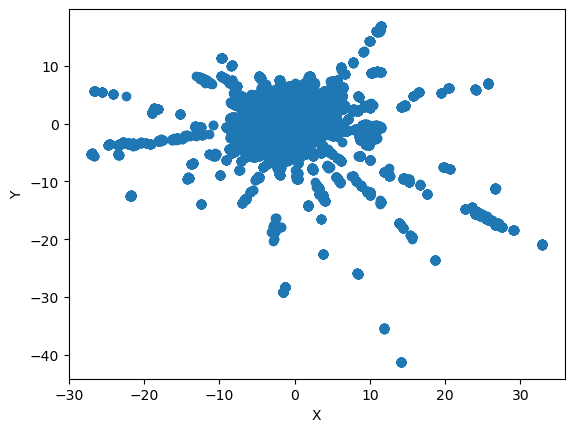

In [70]:
import matplotlib.pyplot as plt
import numpy as np

plt.scatter(emb[:, 0], emb[:, 1])

plt.xlabel("X")
plt.ylabel("Y")

# 显示图形
plt.show()